In [8]:
from datetime import datetime
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import mplfinance as mpf
from pyalgotrade import strategy, plotter
from pyalgotrade.technical import bollinger
from pyalgotrade.stratanalyzer import returns, sharpe, trades, drawdown
from pyalgotrade.barfeed import csvfeed
from pyalgotrade.bar import Frequency
from pyalgotrade.broker import backtesting, slippage
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

/home/VENV36/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


<div class="jumbotron">
    <p class="display-1 h1">实盘交易</p>
    <hr class="my-4">
    <p>主讲：李岩</p>
    <p>管理学院</p>
    <p>liyan@cumtb.edu.cn</p>
</div>

- 实盘交易需要考虑的问题
    - 交易成本
    - 风险控制
    - 交易系统

# 交易成本

- 交易成本（transaction cost）：买卖标的品种所需要的成本

- 分类
    - 显性交易成本：在交易之前可以准确测算
    - 隐性交易成本：在交易过程中由于市场环境等因素的不确定性产生

## 显性交易成本

### 手续费

- 手续费（commissions and fees）：交给经纪商（brokerages）和交易所（exchanges）的费用

- 期货交易手续费有两种表示方法

1. 交易金额的固定比例，比如，`rb`的手续费率为0.1&permil;

- `rb2101`的开仓成交价为3627元，则手续费为$3627\times 10\times 0.1$&permil;$=3.63$元

2. 每手的固定金额，比如，`ru`的手续费额为3元/手

- `rb`基于布林线的均值回归策略，累积盈利$3165$元，交易次数为$266$次
    - 一次完整交易（开平）手续费为$7.26$元，总手续费为$7.26\times 266=1931$元

### `pyalgotrade`中手续费的设置

```python
    pyalgotrade.broker.backtesting.TradePercentage(percentage)
    pyalgotrade.broker.backtesting.FixedPerTrade(amount)
```
- `percentage`：比例
- `amount`：金额

#### 设置手续费

<center><img src="./img/realTrading/commissionSetting.png" width=100%></center>

In [44]:
class myBBands(strategy.BacktestingStrategy):
    
    def __init__(self, feed, instrument, bBandsPeriod, numDev, initEquity, lots):
        super(myBBands, self).__init__(feed, initEquity)
        self.__instrument = instrument
        self.__bbands = bollinger.BollingerBands(feed[instrument].getCloseDataSeries(), bBandsPeriod, numDev)
        self.__positivePosition = None
        self.__negativePosition = None
        self.__commission = 0
        self.__lots = lots

    def getBollingerBands(self):
        return self.__bbands
    
    def getCommission(self):
        return self.__commission
    
    def onExitOk(self, position):
        order = position.getExitOrder()
        execInfo = order.getExecutionInfo()
        self.__commission += execInfo.getCommission()
        self.info(f'{self.action_type(order)}，价格为{execInfo.getPrice():.2f}，手续费为{execInfo.getCommission():.2f}')
        if self.__negativePosition == position:
            self.__negativePosition = None
        elif self.__positivePosition == position:
            self.__positivePosition = None
        
    def onEnterOk(self, position):
        order = position.getEntryOrder()
        execInfo = order.getExecutionInfo()
        self.__commission += execInfo.getCommission()
        self.info(f'{self.action_type(order)}，价格为{execInfo.getPrice():.2f}，手续费为{execInfo.getCommission():.2f}')
        
    def action_type(self, order):
        actionType = order.getAction()
        typeMeaning = ''
        if actionType == 1:
            typeMeaning = '建多仓'
        elif actionType == 2:
            typeMeaning = '平空仓'
        elif actionType == 3:
            typeMeaning = '平多仓'
        elif actionType == 4:
            typeMeaning = '建空仓'
        return typeMeaning
            

    def onBars(self, bars):
        lower = self.__bbands.getLowerBand()[-1]
        upper = self.__bbands.getUpperBand()[-1]
        if lower is None:
            return

        bar = bars[self.__instrument]
        
        if bar.getClose() < lower:
            if self.__negativePosition is not None and self.__negativePosition.exitActive() is False:
                # 有空仓，并且没有平空仓的挂单
                self.__negativePosition.exitMarket()
            if self.__positivePosition is None:
                # 没有多仓
                self.__positivePosition = self.enterLong(self.__instrument, self.__lots)
        elif bar.getClose() > upper:
            if self.__positivePosition is not None and self.__positivePosition.exitActive() is False:
                # 有多仓，并且没有平多仓的挂单
                self.__positivePosition.exitMarket()
            if self.__negativePosition is None:
                # 没有空仓
                self.__negativePosition = self.enterShort(self.__instrument, self.__lots)

In [45]:
def read_data(instrument):
    strFeed = yahoofeed.Feed()
    strFeed.addBarsFromCSV(instrument,'./data/performance/maotai.csv')
    return strFeed

In [46]:
def main():
    instrument = 'maotai'
    bBandsPeriod = 40
    numDev = 3
    feed = read_data(instrument)
 
    # 建立比例手续费对象
    cmFee = backtesting.TradePercentage(0.001)
    slip = slippage.VolumeShareSlippage(100)
        
    strat = myBBands(feed, instrument, bBandsPeriod, numDev, 50000, 5)
    
    # 给策略对应的broker设置手续费
    strat.getBroker().setCommission(cmFee)
    strat.run()
    
    finalEquity = strat.getResult()
    
    print(f'最终权益为：{finalEquity:.2f}')
    print(f'手续费为：{strat.getCommission():.2f}')
    print(f'最终权益(不考虑手续费)为：{finalEquity+strat.getCommission():.2f}')

In [47]:
main()

2010-11-11 00:00:00 strategy [INFO] 建空仓，价格为136.73，手续费为0.68
2012-11-20 00:00:00 strategy [INFO] 平空仓，价格为175.91，手续费为0.88
2012-11-20 00:00:00 strategy [INFO] 建多仓，价格为175.91，手续费为0.88
2013-05-10 00:00:00 strategy [INFO] 平多仓，价格为162.82，手续费为0.81
2013-05-10 00:00:00 strategy [INFO] 建空仓，价格为162.82，手续费为0.81
2013-07-22 00:00:00 strategy [INFO] 平空仓，价格为145.17，手续费为0.73
2013-07-22 00:00:00 strategy [INFO] 建多仓，价格为145.17，手续费为0.73
2014-07-15 00:00:00 strategy [INFO] 平多仓，价格为135.55，手续费为0.68
2014-07-15 00:00:00 strategy [INFO] 建空仓，价格为135.55，手续费为0.68
2014-11-06 00:00:00 strategy [INFO] 平空仓，价格为132.86，手续费为0.66
2014-11-06 00:00:00 strategy [INFO] 建多仓，价格为132.86，手续费为0.66
2014-12-05 00:00:00 strategy [INFO] 平多仓，价格为161.81，手续费为0.81
2014-12-05 00:00:00 strategy [INFO] 建空仓，价格为161.81，手续费为0.81
2015-07-28 00:00:00 strategy [INFO] 平空仓，价格为199.86，手续费为1.00
2015-07-28 00:00:00 strategy [INFO] 建多仓，价格为199.86，手续费为1.00
2015-12-22 00:00:00 strategy [INFO] 平多仓，价格为226.80，手续费为1.13
2015-12-22 00:00:00 strategy [INFO] 建空仓，价格为226.80，手续费为1.

最终权益为：49554.39
手续费为：52.12
最终权益(不考虑手续费)为：49606.51


## 隐性交易成本

### 价格冲击

- 某一订单提交到市场后，引起交易品种价格的变化

- 如果建立某个交易品种的**多头**仓位，该交易品种的价格通常会**上涨**
- 如果建立某个交易品种的**空头**仓位，该交易品种的价格通常会**下跌**

- 价格冲击通常受到**订单大小**与下单时市场上的**流动性**之间的相对关系的影响

### 滑点

- 滑点（slippage）：决定交易时候的市场价格与订单被真正执行时候市场价格之间的差，又被称作“延误成本”

<center><img src="./img/realTrading/slippage.png" width=100%></center>

- 多单的期望建仓价格为$100$元，但是实际执行的价格是$105$元，$5$元即为滑点

#### 影响滑点大小的因素

- 趋势追踪策略易于受到滑点的负面影响

- 价格波动越剧烈，越易出现滑点

- 通信延迟越大，越易出现滑点

### `pyalgotrade`滑点设置

```python
    pyalgotrade.broker.slippage.VolumeShareSlippage(priceImpact=0.1)
```
- `priceImpact`：下单规模对市场价格影响的程度

#### 原理

$$
P=P_0(1+MI)
$$
- $P$：考虑滑点后的价格
- $P_0$：希望的成交价格
- $MI$：价格对市场的冲击

$$
MI = \text{priceImpactConst}\times \bigl(\frac{\text{订单规模}}{\text{总成交量}}\bigr)^2
$$

#### 使用滑点设置

<center><img src="./img/realTrading/slippageSetting.png" width=100%></center>

In [85]:
def main_slippage(inputEquity, inputLots, slippageConst):
    instrument = 'rb'
    multiplier = 10
    bBandsPeriod = 40
    numDev = 3
    feed = read_data(instrument)
 
    # 建立比例手续费对象
#     cmFee = backtesting.TradePercentage(0.001)
    slip = slippage.VolumeShareSlippage(slippageConst)
        
    strat = myBBands(feed, instrument, bBandsPeriod, numDev, inputEquity, inputLots)
    
    # 给策略对应的broker设置手续费
#     strat.getBroker().setCommission(cmFee)

    # 设置滑点
    strat.getBroker().getFillStrategy().setSlippageModel(slip)
    strat.run()
    
    finalEquity = strat.getResult()
    return finalEquity

In [80]:
print(f'最终权益为：{main_slippage(50000,5,0.01):.2f}')

最终权益为：53165.00


#### 价格影响因子的作用

In [101]:
equityLst = []
priceImpactLst = [0.1, 10, 100, 1000]
for each in priceImpactLst:
    equityLst.append(main_slippage(500000,50, each))

df = pd.DataFrame({'影响因子':priceImpactLst, '最终权益':equityLst})
df

,影响因子,最终权益
0,0.1,531644.097779
1,10.0,531059.777875
2,100.0,525747.778750
3,1000.0,472627.787500


#### 订单规模的影响

In [99]:
orderSizeLst = [10, 50, 100]
equityLst1 = []
for each in orderSizeLst:
    equityLst1.append(main_slippage(500000, each, 100))
    
df1 = pd.DataFrame({'订单规模':orderSizeLst, '最终权益':equityLst1})
df1

,订单规模,最终权益
0,10,506282.78223
1,50,525747.77875
2,100,516082.23000


# 量化交易风险 

## 交易风险的来源

<center><img src="./img/realTrading/risk1.png" width=100%></center>

### 模型风险

- 回测时候的过拟合

- 交易逻辑的不完善

- 例，2016年11月11日（周五）夜盘，棉花期货开盘涨停之后又跌停

In [29]:
cfdf = pd.read_csv('./data/realTrading/CF701_20161111.csv')
cfdf['Date Time'] = pd.to_datetime(cfdf['Date Time'],format='%Y-%m-%d %H:%M:%S')
cfdf.set_index('Date Time',inplace=True)
cfdf.head()

,open,high,low,close,volume
Date Time,,,,,
2016-11-11 13:30:00,15245.0,15290.0,15220.0,15265.0,3820.0
2016-11-11 13:31:00,15255.0,15290.0,15250.0,15285.0,878.0
2016-11-11 13:32:00,15285.0,15285.0,15240.0,15260.0,1454.0
2016-11-11 13:33:00,15255.0,15280.0,15255.0,15275.0,980.0
2016-11-11 13:34:00,15275.0,15320.0,15275.0,15305.0,1872.0


In [59]:
mc = mpf.make_marketcolors(up='#fe3032',down='#00b060',inherit=True)
ms = mpf.make_mpf_style(base_mpf_style='yahoo',marketcolors=mc)

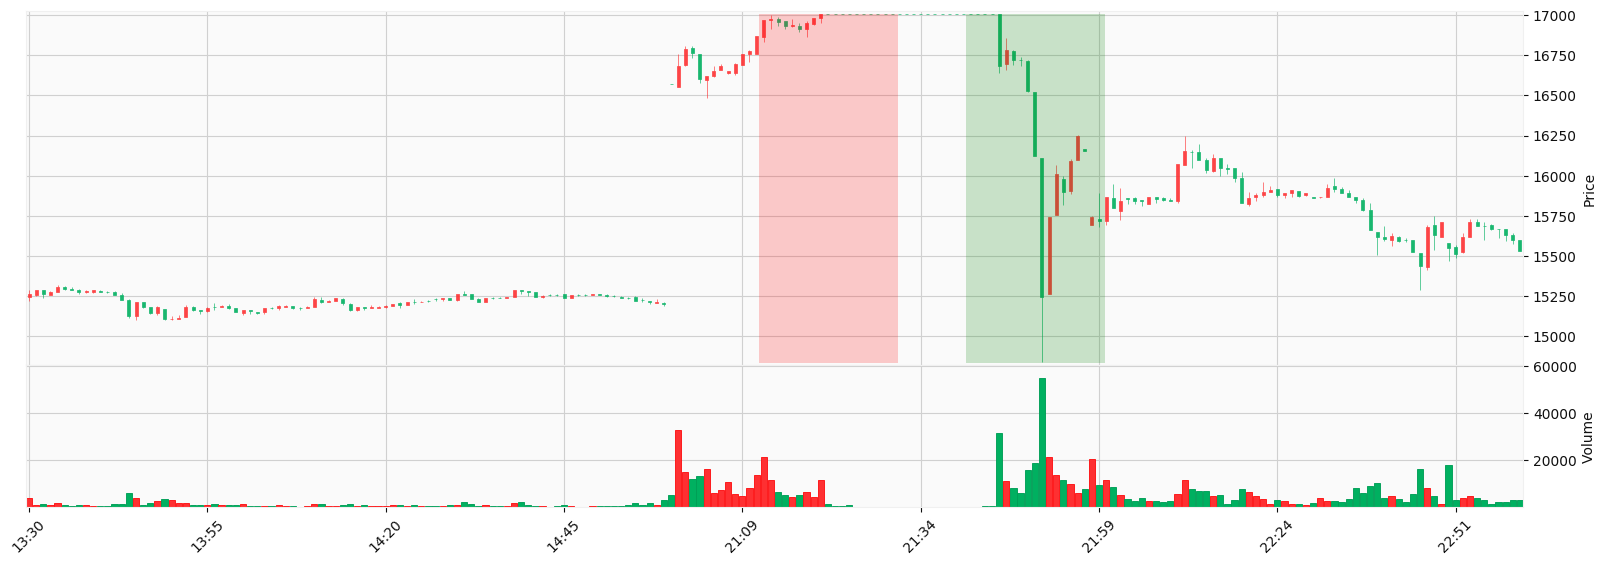

In [60]:
mpf.plot(cfdf,type='candle',style=ms,volume=True,figratio=(12,4),figscale=1.0,tight_layout=True,vlines={'vlines':['2016-11-11 21:21','2016-11-11 21:50'],'linewidths':[100,100],'colors':['r','g'],'alpha':0.2})

> 。。。白天持有一万吨的买棕油卖菜油的套利头寸，夜盘开盘暴涨，她慌了，追着市场砍掉了一万吨菜油的空头；刚砍完菜油的空头，棕油跳水了！她又追着砍了棕油的多头。。。检讨中她跟我道歉说一下子损失了300多万。。。

### 执行风险

- 执行系统接收不到交易信号

- 漏掉经纪商柜台系统或交易所系统的回报

### 技术风险

- 系统程序实施错误

- 电脑死机

- 网络传输中断

- 例，2012年8月份，骑士资本（Knight）交易系统的一个bug使得处于休眠状态的模块突然上线，不断复制仓位，造成骑士资本以不断上涨的价格增加仓位。
    - 当平掉这些仓位的时候，骑士资本有了9位数的损失

<center><img src="./img/realTrading/risk2.png" width=100%></center>

### 系统性风险

- 同质化投资策略加剧了市场的波动

- 同时触及各个程序化交易的止损价位，导致市场“羊群效应”的出现

> [一场由程序员“背锅”的股灾：1987年的黑色星期一 http://reader.epubee.com/books/mobile/ee/ee4f0d86257d26f803236b30238fe63a/text00008.html](http://reader.epubee.com/books/mobile/ee/ee4f0d86257d26f803236b30238fe63a/text00008.html)

In [23]:
dji = web.DataReader('^DJI','stooq',start=datetime(1987,7,1),end=datetime(1987,12,1))
dji.sort_index(ascending=True,inplace=True)
dji.head()

,Open,High,Low,Close,Volume
Date,,,,,
1987-07-01,2418.5,2430.8,2391.3,2409.8,18531349
1987-07-02,2415.7,2446.3,2415.7,2436.7,17821316
1987-07-06,2436.7,2460.3,2413.0,2429.5,21377828
1987-07-07,2429.5,2467.6,2425.1,2449.8,24925114
1987-07-08,2449.8,2476.2,2432.6,2464.0,25019823


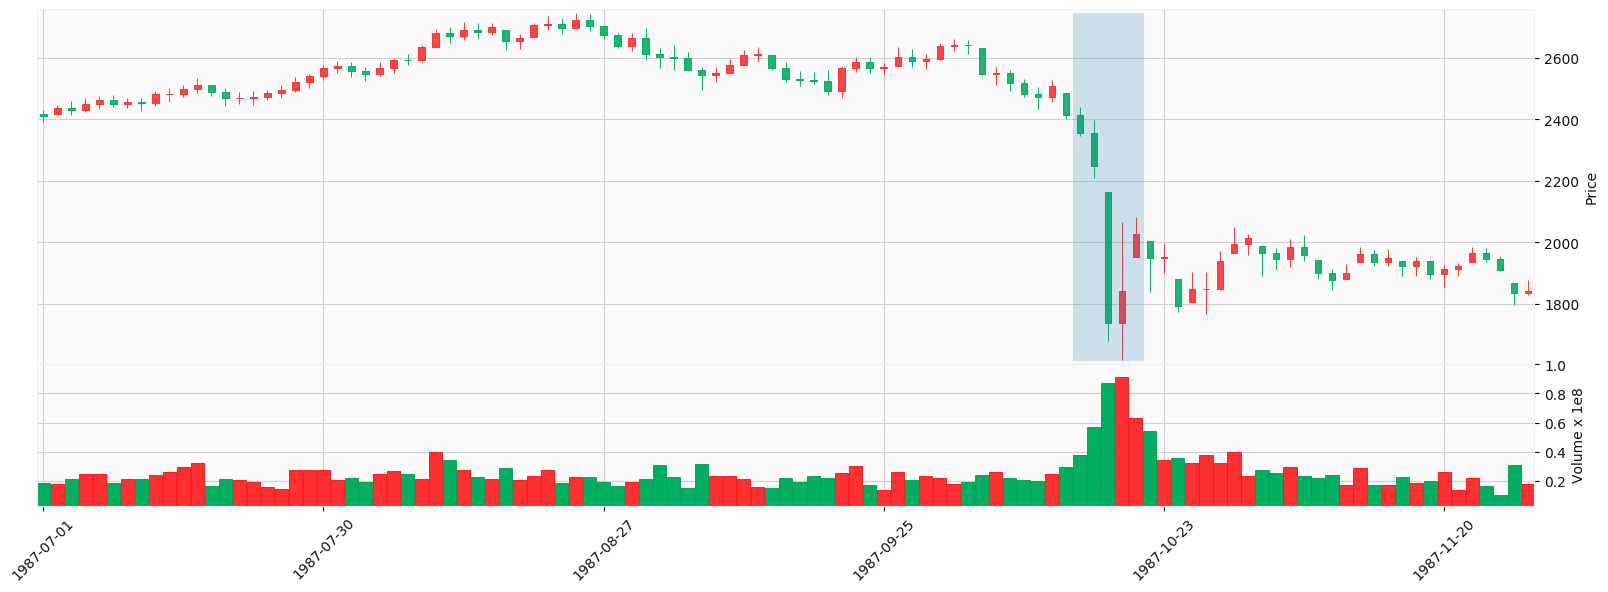

In [62]:
mpl.plot(dji,type='candle',style=ms,volume=True,figratio=(12,4),figscale=1.0,tight_layout=True,datetime_format='%Y-%m-%d',vlines={'vlines':'1987-10-19','linewidths':50,'alpha':0.2})

## 量化交易风险的控制

- 模型风险的控制
    - 止损、止盈
    - 仓位控制

### 仓位控制

- 仓位控制是对风险最直接的控制方法

- Kelly公式：最优仓位比例

$$
    f=p-\frac{1-p}{b}=\frac{bp-(1-p)}{b}
$$
- $p$：交易胜率
- $b$：平均盈利/平均亏损

### 仓位比例计算示例

In [31]:
from pyalgotrade import strategy, plotter
from pyalgotrade.technical import bollinger
from pyalgotrade.stratanalyzer import returns, sharpe, trades, drawdown
from pyalgotrade.barfeed import yahoofeed

In [32]:
class myBBands(strategy.BacktestingStrategy):
    
    def __init__(self, feed, instrument, bBandsPeriod, numDev, initEquity):
        super(myBBands, self).__init__(feed, initEquity)
        self.__instrument = instrument
        self.__bbands = bollinger.BollingerBands(feed[instrument].getCloseDataSeries(), bBandsPeriod, numDev)
        self.__longPosition = None

    def getBollingerBands(self):
        return self.__bbands
    
    def onExitOk(self, position):
        order = position.getExitOrder()
        execInfo = order.getExecutionInfo()
        self.info(f'{self.action_type(order)}，价格为{execInfo.getPrice():.2f}')
        if self.__longPosition == position:
            self.__longPosition = None
        
    def onEnterOk(self, position):
        order = position.getEntryOrder()
        execInfo = order.getExecutionInfo()
        self.info(f'{self.action_type(order)}，价格为{execInfo.getPrice():.2f}')
        
    def action_type(self, order):
        actionType = order.getAction()
        typeMeaning = ''
        if actionType == 1:
            typeMeaning = '建多仓'
        elif actionType == 2:
            typeMeaning = '平空仓'
        elif actionType == 3:
            typeMeaning = '平多仓'
        elif actionType == 4:
            typeMeaning = '建空仓'
        return typeMeaning
            

    def onBars(self, bars):
        lower = self.__bbands.getLowerBand()[-1]
        upper = self.__bbands.getUpperBand()[-1]
        if lower is None:
            return

        bar = bars[self.__instrument]
        
        if bar.getClose() < lower:
            if self.__longPosition is None:
                # 没有多仓
                self.__longPosition = self.enterLong(self.__instrument, 5)
        elif bar.getClose() > upper:
            if self.__longPosition is not None and self.__longPosition.exitActive() is False:
                # 有多仓，并且没有平多仓的挂单
                self.__longPosition.exitMarket()

In [33]:
def strategy_evaluation(inputStrategy):
    retAnalyzer = returns.Returns()
    sharpeAnalyzer = sharpe.SharpeRatio()
    ddAnalyzer = drawdown.DrawDown()
    tradesAnalyzer = trades.Trades()
    
    inputStrategy.attachAnalyzer(retAnalyzer)
    inputStrategy.attachAnalyzer(sharpeAnalyzer)
    inputStrategy.attachAnalyzer(ddAnalyzer)
    inputStrategy.attachAnalyzer(tradesAnalyzer)
    
    return retAnalyzer, sharpeAnalyzer, ddAnalyzer, tradesAnalyzer

In [34]:
def read_data(instrument):
    strFeed = yahoofeed.Feed()
    strFeed.addBarsFromCSV(instrument,'./data/performance/maotai.csv')
    return strFeed

In [35]:
def main():
    instrument = 'maotai'
    bBandsPeriod = 20
    numDev = 2
    feed = read_data(instrument)
    
    strat = myBBands(feed, instrument, bBandsPeriod, numDev, 50000)
    
    retEval, sharpeEval, ddEval, tradesEval = strategy_evaluation(strat)
    
    strat.run()
    
    print(f'最终权益为：{strat.getResult()}')
    print(f'最终累积收益率为：{retEval.getCumulativeReturns()[-1]*100:.2f}%')
    print(f'Sharpe Ratio为：{sharpeEval.getSharpeRatio(0.03):.2f}')
    print(f'最大回撤为：{ddEval.getMaxDrawDown()*100:.2f}%')
    print(f'最长回撤时间为：{ddEval.getLongestDrawDownDuration()}')
    print(f'总交易次数为：{tradesEval.getCount()}')
    if tradesEval.getCount() > 0:
        print(f'胜率为：{tradesEval.getProfitableCount()/tradesEval.getCount()*100:.2f}%')
    return retEval, tradesEval

In [36]:
ret, trades = main()

2010-03-16 00:00:00 strategy [INFO] 建多仓，价格为119.23
2010-06-07 00:00:00 strategy [INFO] 平多仓，价格为102.93
2010-10-15 00:00:00 strategy [INFO] 建多仓，价格为119.10
2010-11-11 00:00:00 strategy [INFO] 平多仓，价格为136.73
2010-12-28 00:00:00 strategy [INFO] 建多仓，价格为137.49
2011-03-18 00:00:00 strategy [INFO] 平多仓，价格为142.41
2011-09-15 00:00:00 strategy [INFO] 建多仓，价格为163.64
2011-11-29 00:00:00 strategy [INFO] 平多仓，价格为176.69
2011-12-28 00:00:00 strategy [INFO] 建多仓，价格为155.62
2012-02-27 00:00:00 strategy [INFO] 平多仓，价格为164.28
2012-08-20 00:00:00 strategy [INFO] 建多仓，价格为189.76
2013-04-18 00:00:00 strategy [INFO] 平多仓，价格为146.45
2013-06-18 00:00:00 strategy [INFO] 建多仓，价格为156.33
2014-01-23 00:00:00 strategy [INFO] 平多仓，价格为110.89
2014-05-20 00:00:00 strategy [INFO] 建多仓，价格为122.40
2014-06-24 00:00:00 strategy [INFO] 平多仓，价格为129.44
2014-08-28 00:00:00 strategy [INFO] 建多仓，价格为141.82
2014-09-09 00:00:00 strategy [INFO] 平多仓，价格为152.41
2014-10-15 00:00:00 strategy [INFO] 建多仓，价格为140.68
2014-12-04 00:00:00 strategy [INFO] 平多仓，价格为151.36


最终权益为：53487.39540100098
最终累积收益率为：6.97%
Sharpe Ratio为：-2.65
最大回撤为：1.76%
最长回撤时间为：1789 days, 0:00:00
总交易次数为：22
胜率为：81.82%


#### 仓位比例计算

In [39]:
totTrades = trades.getCount()
p = trades.getProfitableCount()/totTrades
print(f'胜率为{p:.2f}')
aveGain = trades.getProfits().mean()
print(f'平均盈利{aveGain:.2f}')
aveLoss = trades.getLosses().mean()
print(f'平均亏损{aveLoss:.2f}')
b = aveGain/np.abs(aveLoss)
fpct = (b*p-(1-p))/b
fpct

胜率为0.82
平均盈利224.59
平均亏损-138.82


0.7058008013676135

- 最优仓位比例是70.5%

# 交易系统

## 国内期货市场的交易系统

- 交易所系统
- 经纪商系统
- 投资者系统

- 交易所系统：交易撮合队列、行情服务器

- 经纪商柜台系统：以CTP为代表，
    - 用于接收客户订单、前端风控
    - 接收交易所推送的行情

- 投资者系统
    - 连接柜台、行情服务器
    - 启动和关闭交易策略

### 三套系统之间的交互

<center><img src="./img/realTrading/systems.svg" width=100%></center>

### CTP接口

- 综合交易平台（Comprehensive Transaction Platform）
    - 由上海期货交易所的上海期货信息技术有限公司开发 [http://www.sfit.com.cn/](http://www.sfit.com.cn/)
    - 适用于期货公司的期货经纪业务管理系统

- CTP的组成
<center><img src="./img/realTrading/ctp.png" width=100%></center>

- CTP能够同时连通上海期货交易所、大连商品交易所、郑州商品交易所、中国金融期货交易所
- 支持国内商品期货和股指期货的交易和结算业务

- 分别对应交易接口（`Trader API`）、风控接口(`Risk API`)、结算接口（`CSV`）

### `Trader API`

- 最新版本是v6.3.19_P1

文件名|功能说明
---|---
`ThostFtdcTraderApi.h`|`C++`头文件，包含交易相关的指令
`ThostFtdcMdApi.h`|`C++`头文件，包含获取行情相关的指令
`ThostFtdcUserApiStruct.h`|包含所有需要的数据结构
`ThostFtdcUserApiDataType.h`|包含所有需要用到的数据类型
`thosttraderapi_se.dll`|交易相关的动态链接库
`thosttraderapi_se.lib`|交易相关的静态链接库
`thostmduserapi_se.dll`|行情相关的动态链接库
`thostmduserapi_se.lib`|行情相关的静态链接库
`error.dtd`|所有可能的错误信息
`error.xml`|所有可能的错误信息

- 用户只需要关注`.h`文件

#### `API`接口包含的两个***类***

- `Spi`类：包含所有的响应和回报函数，接收CTP发送的消息

- `Api`类：用户主动向CTP发起请求和订阅的函数

<center><img src="./img/realTrading/ctpApiSpi.svg" width=100%></center>

## 国内量化交易平台

- 优矿 [https://uqer.datayes.com/](https://uqer.datayes.com/)
- BigQuant [https://bigquant.com/](https://bigquant.com/)
- 聚宽 [https://www.joinquant.com/](https://www.joinquant.com/)
- 掘金量化 [https://www.myquant.cn/](https://www.myquant.cn/)
- 米筐 [https://www.ricequant.com/welcome/](https://www.ricequant.com/welcome/)
- MindGo [http://quant.10jqka.com.cn/platform/html/home.html](http://quant.10jqka.com.cn/platform/html/home.html)
- 万矿 [https://www.windquant.com](https://www.windquant.com)
- 国泰君安量化交易系统 [https://quant.gtja.com](https://quant.gtja.com)
- 点宽 [http://www.digquant.info](http://www.digquant.info)

### 构建一个交易策略主要使用的函数

```python
    def initialize(context):
        # 初始化函数，初始化策略的基本参数
        pass
    
    def handle_data(context, data):
        # 主交易逻辑
        pass
```